In [46]:
pip install transformers torch sentencepiece

In [81]:
import re
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from transformers import pipeline
import matplotlib.pyplot as plt
from textblob import TextBlob
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix as cm
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from wordcloud import WordCloud, STOPWORDS
from sklearn.preprocessing import LabelEncoder
from nltk.stem import PorterStemmer
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('wordnet')
from nltk.corpus import stopwords
import pickle
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [48]:
df = pd.read_csv('final_merged_flipkart_reviews.csv')

In [49]:
df.head()

,Product,Overall Rating,Review
0,"REDMI Note 14 Pro+ 5G (Titan Black, 512 GB) (...",4.3,...Battery performance super Back Camera super...
1,"REDMI Note 14 Pro+ 5G (Titan Black, 512 GB) (...",4.3,...the camera is a little low quality...otherw...
2,"REDMI Note 14 Pro+ 5G (Titan Black, 512 GB) (...",4.3,...almost 1 and a half days Or more than that....
3,"REDMI Note 14 Pro+ 5G (Titan Black, 512 GB) (...",4.3,...month of use. Excellent work from Redmi. Ca...
4,"REDMI Note 14 Pro+ 5G (Titan Black, 512 GB) (...",4.3,...Good phone. The camera could have been bett...


In [50]:
df.shape

(40849, 3)

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40849 entries, 0 to 40848
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Product         40849 non-null  object
 1   Overall Rating  40849 non-null  object
 2   Review          40849 non-null  object
dtypes: object(3)
memory usage: 957.5+ KB


In [52]:
df.isnull().sum()

,0
Product,0
Overall Rating,0
Review,0


In [53]:
df['Overall Rating'].value_counts()

,count
Overall Rating,
4.4,16442
4.3,8904
4.2,5790
4.5,4725
4.6,3468
4.1,880
No Rating,480
4.8,160


In [54]:
df = df[df['Overall Rating'] != 'No Rating']

In [55]:
df['Overall Rating'].value_counts()

,count
Overall Rating,
4.4,16442
4.3,8904
4.2,5790
4.5,4725
4.6,3468
4.1,880
4.8,160


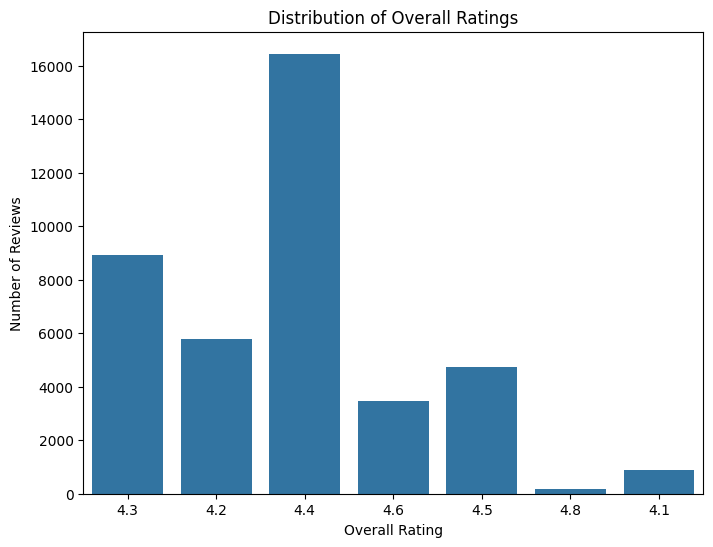

In [56]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Overall Rating', data=df)
plt.title('Distribution of Overall Ratings')
plt.xlabel('Overall Rating')
plt.ylabel('Number of Reviews')
plt.show()

In [57]:
sentiment_model = pipeline("text-classification", model="cardiffnlp/twitter-roberta-base-sentiment")

Device set to use cuda:0


In [58]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

lemmatizer = WordNetLemmatizer()

def cleanReviews(text):
    """Cleans the input text and applies stemming."""
    if not isinstance(text, str) or not text.strip():
        return ""

    # Remove emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    # Convert to lowercase
    text = text.lower()

    # Remove mentions, hashtags, URLs, and special characters
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)  # Remove @mentions
    text = re.sub(r'#', '', text)  # Remove hashtags
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove special characters & punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces

    # Apply stemming
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

    return text

In [59]:
df["cleanedReviews"] = df["Review"].apply(cleanReviews)

In [60]:
df.head()

,Product,Overall Rating,Review,cleanedReviews
0,"REDMI Note 14 Pro+ 5G (Titan Black, 512 GB) (...",4.3,...Battery performance super Back Camera super...,battery performance super back camera super fr...
1,"REDMI Note 14 Pro+ 5G (Titan Black, 512 GB) (...",4.3,...the camera is a little low quality...otherw...,the camera is a little low qualityotherwise ev...
2,"REDMI Note 14 Pro+ 5G (Titan Black, 512 GB) (...",4.3,...almost 1 and a half days Or more than that....,almost 1 and a half day or more than that the ...
3,"REDMI Note 14 Pro+ 5G (Titan Black, 512 GB) (...",4.3,...month of use. Excellent work from Redmi. Ca...,month of use excellent work from redmi camera ...
4,"REDMI Note 14 Pro+ 5G (Titan Black, 512 GB) (...",4.3,...Good phone. The camera could have been bett...,good phone the camera could have been betterre...


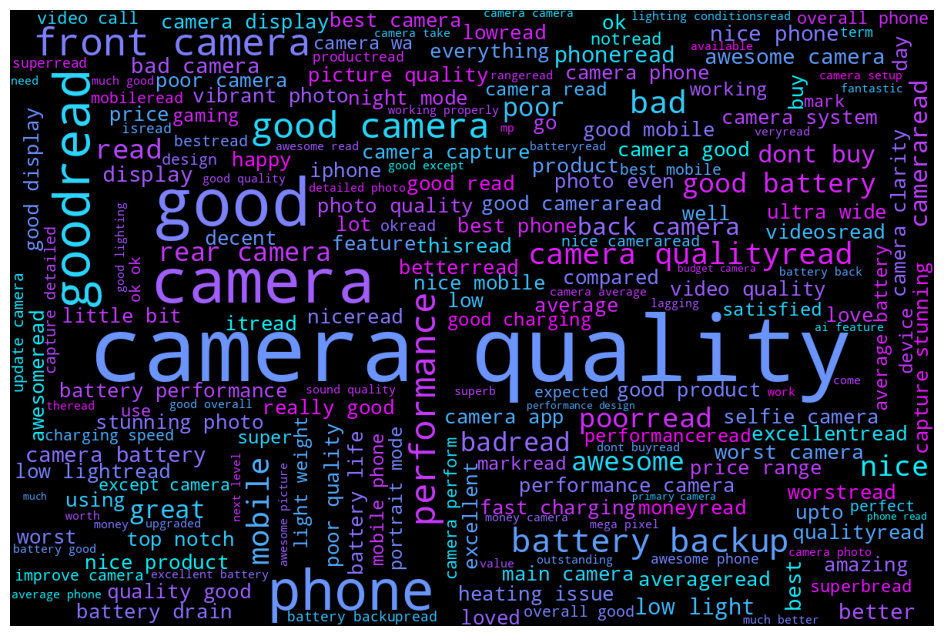

In [61]:
text = " ".join(df['cleanedReviews'])

stopwords = set(STOPWORDS)

wordcloud = WordCloud(stopwords=stopwords,
                      background_color="black",
                      colormap="cool",
                      width=1200,
                      height=800,
                      max_words=200,
                      contour_color='white',
                      contour_width=2).generate(text)

# Display the WordCloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='antialiased')
plt.axis("off")
plt.show()

In [62]:
def analyze_sentiment(text):
    cleaned_text = cleanReviews(text)
    result = sentiment_model(cleaned_text)[0]

    label = result['label']
    score = result['score']

    if label == "LABEL_2":
        sentiment = "Positive"
    elif label == "LABEL_0":
        sentiment = "Negative"
    else:
        sentiment = "Neutral"

    return pd.Series([sentiment, score])

df[['Sentiment', 'Sentiment Score']] = df['cleanedReviews'].apply(analyze_sentiment)

In [63]:
reviews = [
    "It's not a bad product",
    "It's not very amazing",
    "I absolutely love this!",
    "This is the worst purchase ever!",
    "I don't hate it, but I don't love it either.",
    "Not great, not terrible.",
    "Wow, this exceeded my expectations!",
    "This was supposed to be great, but it isn't.",
    "I was expecting better.",
    "Could be worse, but also could be better.",
]

for review in reviews:
    print(f"Review: {review} -> Sentiment: {analyze_sentiment(review)}")

Review: It's not a bad product -> Sentiment: 0    Positive
1    0.624269
dtype: object
Review: It's not very amazing -> Sentiment: 0    Negative
1    0.925844
dtype: object
Review: I absolutely love this! -> Sentiment: 0    Positive
1     0.98328
dtype: object
Review: This is the worst purchase ever! -> Sentiment: 0    Negative
1    0.978443
dtype: object
Review: I don't hate it, but I don't love it either. -> Sentiment: 0    Negative
1    0.579884
dtype: object
Review: Not great, not terrible. -> Sentiment: 0    Negative
1    0.645729
dtype: object
Review: Wow, this exceeded my expectations! -> Sentiment: 0    Positive
1    0.785143
dtype: object
Review: This was supposed to be great, but it isn't. -> Sentiment: 0    Negative
1    0.620086
dtype: object
Review: I was expecting better. -> Sentiment: 0     Neutral
1    0.558613
dtype: object
Review: Could be worse, but also could be better. -> Sentiment: 0     Neutral
1    0.479705
dtype: object


In [64]:
df.head()

,Product,Overall Rating,Review,cleanedReviews,Sentiment,Sentiment Score
0,"REDMI Note 14 Pro+ 5G (Titan Black, 512 GB) (...",4.3,...Battery performance super Back Camera super...,battery performance super back camera super fr...,Positive,0.644004
1,"REDMI Note 14 Pro+ 5G (Titan Black, 512 GB) (...",4.3,...the camera is a little low quality...otherw...,the camera is a little low qualityotherwise ev...,Positive,0.814034
2,"REDMI Note 14 Pro+ 5G (Titan Black, 512 GB) (...",4.3,...almost 1 and a half days Or more than that....,almost 1 and a half day or more than that the ...,Negative,0.749893
3,"REDMI Note 14 Pro+ 5G (Titan Black, 512 GB) (...",4.3,...month of use. Excellent work from Redmi. Ca...,month of use excellent work from redmi camera ...,Positive,0.967864
4,"REDMI Note 14 Pro+ 5G (Titan Black, 512 GB) (...",4.3,...Good phone. The camera could have been bett...,good phone the camera could have been betterre...,Positive,0.707839


In [65]:
df.tail()

,Product,Overall Rating,Review,cleanedReviews,Sentiment,Sentiment Score
40844,"MOTOROLA Edge 50 (Peach Fuzz, 256 GB) (8 GB RAM)",4.3,...for heavy users... Performance also good..o...,for heavy user performance also goodonly camer...,Positive,0.907818
40845,"MOTOROLA Edge 50 (Peach Fuzz, 256 GB) (8 GB RAM)",4.3,"...This is good phone,but some camera bug'sI h...",this is good phonebut some camera bugsi hope m...,Positive,0.713946
40846,"MOTOROLA Edge 50 (Peach Fuzz, 256 GB) (8 GB RAM)",4.3,...Outstanding camera and superb quality of ph...,outstanding camera and superb quality of photo...,Positive,0.895420
40847,"MOTOROLA Edge 50 (Peach Fuzz, 256 GB) (8 GB RAM)",4.3,...some people are complaint about camera lag ...,some people are complaint about camera lag but...,Neutral,0.621206
40848,"MOTOROLA Edge 50 (Peach Fuzz, 256 GB) (8 GB RAM)",4.3,...Pros:Awesome design Awesome camera Awesome ...,prosawesome design awesome camera awesome ui f...,Positive,0.955673


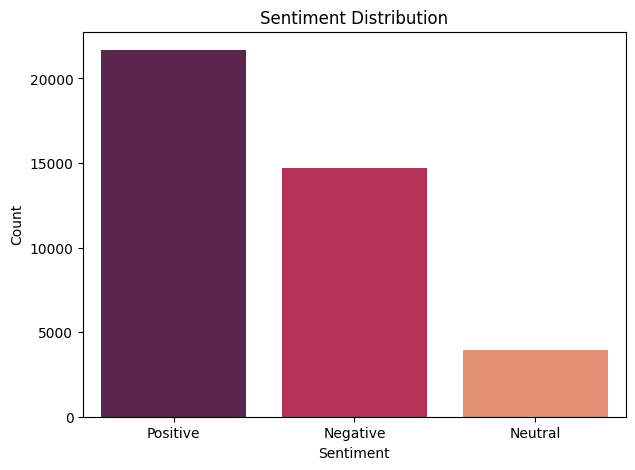

In [66]:
plt.figure(figsize=(7, 5))
sns.countplot(x="Sentiment", data=df, palette="rocket")
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

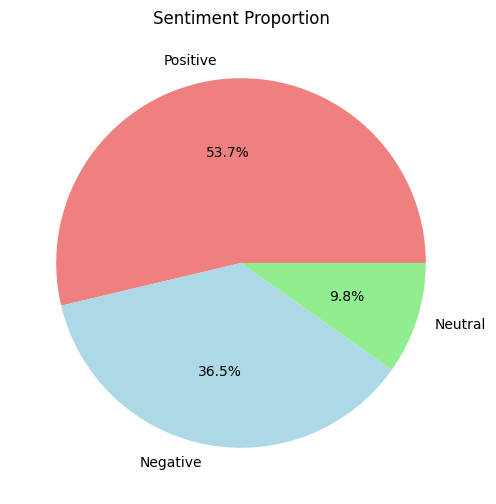

In [67]:
plt.figure(figsize=(6, 6))
df['Sentiment'].value_counts().plot.pie(autopct='%1.1f%%', colors=['lightcoral', 'lightblue', 'lightgreen'])
plt.title("Sentiment Proportion")
plt.ylabel("")
plt.show()

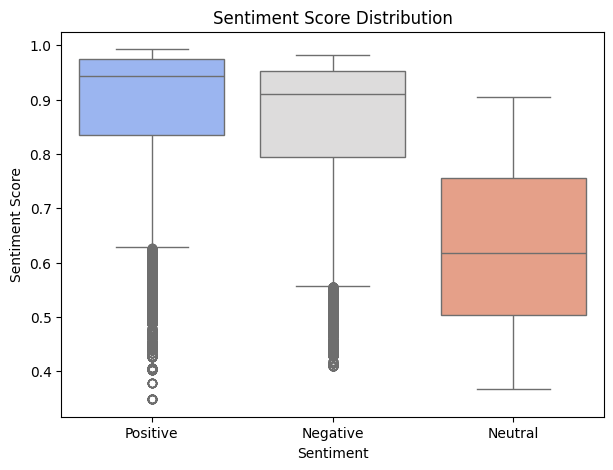

In [68]:
plt.figure(figsize=(7, 5))
sns.boxplot(x="Sentiment", y="Sentiment Score", data=df, palette="coolwarm")
plt.title("Sentiment Score Distribution")
plt.show()

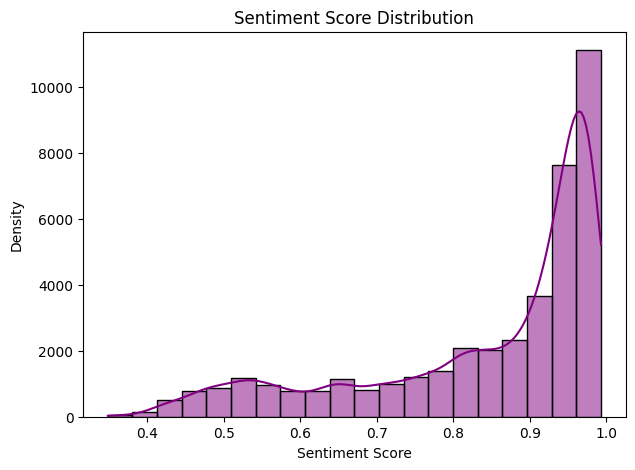

In [69]:
plt.figure(figsize=(7, 5))
sns.histplot(df['Sentiment Score'], bins=20, kde=True, color='purple')
plt.title("Sentiment Score Distribution")
plt.xlabel("Sentiment Score")
plt.ylabel("Density")
plt.show()

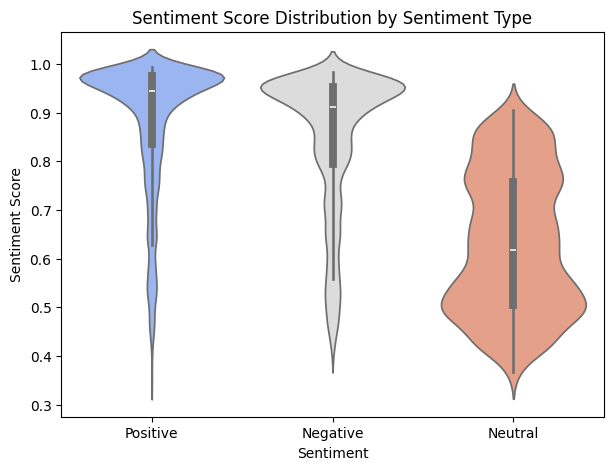

In [70]:
plt.figure(figsize=(7, 5))
sns.violinplot(x="Sentiment", y="Sentiment Score", data=df, palette="coolwarm")
plt.title("Sentiment Score Distribution by Sentiment Type")
plt.show()

In [71]:
min_count = df['Sentiment'].value_counts().min()
df = df.groupby('Sentiment').apply(lambda x: x.sample(min_count)).reset_index(drop=True)

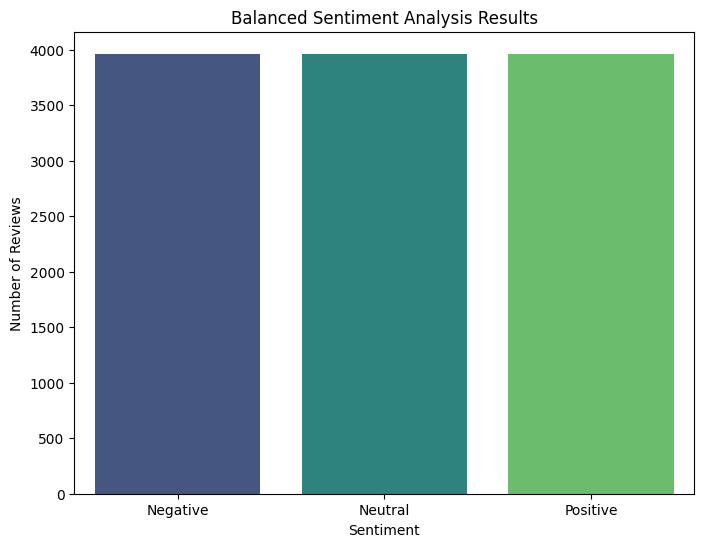

In [72]:
sentiment_counts = df['Sentiment'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
plt.title('Balanced Sentiment Analysis Results')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()

In [73]:
le = LabelEncoder()
df['Sentiment'] = le.fit_transform(df['Sentiment'])

In [74]:
X = df['cleanedReviews']
Y = df['Sentiment']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [75]:
model = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words='english')),
    ('classifier', MultinomialNB())
])

In [76]:
model.fit(X_train, Y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer(stop_words='english')),
                ('classifier', MultinomialNB())])

In [77]:
Y_pred = model.predict(X_test)
Y_pred

array([0, 1, 2, ..., 2, 1, 0])

Accuracy Score: 0.9167717528373266
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.93      0.91       796
           1       0.93      0.91      0.92       801
           2       0.93      0.91      0.92       782

    accuracy                           0.92      2379
   macro avg       0.92      0.92      0.92      2379
weighted avg       0.92      0.92      0.92      2379

Confusion Matrix:


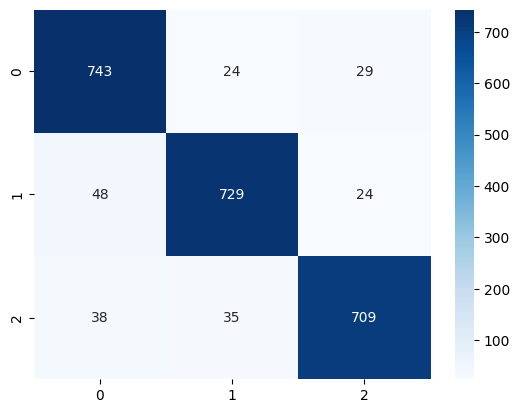

In [78]:
print("Accuracy Score:", accuracy_score(Y_test, Y_pred))
print("Classification Report:\n", classification_report(Y_test, Y_pred))
print("Confusion Matrix:")
sns.heatmap(cm(Y_test, Y_pred), annot=True, fmt='d', cmap='Blues')
plt.show()

In [79]:
def predict_sentiment(review):
    review = cleanReviews(review)
    prediction = model.predict([review])[0]
    return le.inverse_transform([prediction])[0]

In [80]:
sample_reviews = [
    "The product is amazing! I love it!",
    "Worst product ever. Waste of money!",
    "It's okay, nothing special.",
    "It is not a bad product.",
    "Not great, but not terrible either."
]

for review in sample_reviews:
    print(f"Review: {review} -> Sentiment: {predict_sentiment(review)}")

Review: The product is amazing! I love it! -> Sentiment: Positive
Review: Worst product ever. Waste of money! -> Sentiment: Negative
Review: It's okay, nothing special. -> Sentiment: Neutral
Review: It is not a bad product. -> Sentiment: Negative
Review: Not great, but not terrible either. -> Sentiment: Negative


In [82]:
# Save the model
with open('sentiment_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)